# Test of linear_interp in 1d

## Setup

In [ ]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

In [3]:
# reload module each time cell is run
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import time
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from scipy.interpolate import RegularGridInterpolator
from consav import linear_interp

## Set up functions and grids

In [14]:
# a. functions
@njit
def f(x1):
    return x1**2

@njit
def fill_value(grid1,value):
    for i in range(grid1.size):
        value[i] = f(grid1[i])    

@njit
def grids_points_and_value(Nx1):

    grid1 = np.linspace(low_x1,high_x1,Nx1)

    value = np.empty(Nx1)
    fill_value(grid1,value)
    
    return grid1,value

# b. grid points and value
Nx1 = 150
low_x1,low_x2,low_x3 = 1.0,1.0,1.0
high_x1,high_x2,high_x3 = 10.0,15.0,12.0
grid1,value = grids_points_and_value(Nx1)

# c. scipy
yi_scipy_interp = RegularGridInterpolator([grid1], value, 
                                          method='linear',bounds_error=False,fill_value=None)

## Timings

In [15]:
# preparation
Ntimes = 100
Nfuncs = 5
Nyi = 100000
xi1 = np.sort(np.random.uniform(low=0.9*low_x2,high=1.1*high_x2,size=Nyi))

In [16]:
store = np.empty((Ntimes,Nfuncs))
for i in range(Ntimes):
    tic = time.time()
    yi_scipy_interp = RegularGridInterpolator([grid1],value,
                                              method='linear',bounds_error=False,fill_value=None)
    yi_mon_scipy = yi_scipy_interp(xi1)
    toc = time.time()
    store[i,0] = toc-tic
    
    tic = time.time()
    yi = np.empty(Nyi)
    linear_interp.interp_1d_vec(grid1,value,xi1,yi)
    toc = time.time()
    assert np.allclose(yi_mon_scipy,yi)
    store[i,1] = toc-tic
    
    tic = time.time()
    yi = np.empty(Nyi)
    prep = linear_interp.interp_1d_prep(Nyi)
    linear_interp.interp_1d_vec_mon(prep,grid1,value,xi1,yi)
    toc = time.time()
    assert np.allclose(yi_mon_scipy,yi)
    store[i,2] = toc-tic    
    
    tic = time.time()
    yi = np.empty(Nyi)  
    linear_interp.interp_1d_vec_mon_rep(prep,grid1,value,xi1,yi)
    toc = time.time()
    assert np.allclose(yi_mon_scipy,yi)
    store[i,3] = toc-tic
    
    tic = time.time()
    yi = np.empty(Nyi)
    linear_interp.interp_1d_vec_mon_noprep(grid1,value,xi1,yi)
    toc = time.time()
    assert np.allclose(yi_mon_scipy,yi)
    store[i,4] = toc-tic    

In [17]:
def timings(expr, header, store, Ntimes, unit='ms', ndigits=5):
    
    # summary statistics
    summ = np.transpose(np.vstack(
                              (np.percentile(store, [25,50], axis=0), #lq, median
                               np.mean(store, axis=0),                      #mean
                               np.percentile(store, 75, axis=0))            #uq
                               ))              
    # format times
    factor = {'ms':1E3, 'us':1E6, 'ns':1E9, 's':1}
    summ = np.round(summ*factor[unit], ndigits)
    
    # add neval
    summ = np.hstack((summ, np.ones((5,1))*Ntimes))
    
    # create table
    out = PrettyTable(header)
    for i in range(len(expr)):
        out.add_row([expr[i]]+(summ[i,:].tolist()))
    print('timeunit is:', unit)
    print(out)

In [18]:
expr = ['scipy', 'interp_1d_vec', 'interp_1d_vec_mon', 'interp_1d_vec_mon_rep', 'interp_1d_vec_mon_noprep']
header = ['function', 'lq', 'median', 'mean', 'uq', 'neval']
timings(expr,header,store,Ntimes,unit='ms',ndigits=2)

timeunit is: ms
+--------------------------+------+--------+-------+------+-------+
|         function         |  lq  | median |  mean |  uq  | neval |
+--------------------------+------+--------+-------+------+-------+
|          scipy           | 9.48 | 11.48  | 11.57 | 13.1 | 100.0 |
|      interp_1d_vec       | 3.49 |  3.99  |  4.17 | 4.99 | 100.0 |
|    interp_1d_vec_mon     | 1.99 |  2.0   |  2.31 | 2.99 | 100.0 |
|  interp_1d_vec_mon_rep   | 1.0  |  1.5   |  1.58 | 1.99 | 100.0 |
| interp_1d_vec_mon_noprep | 1.5  |  2.49  |  2.23 | 2.49 | 100.0 |
+--------------------------+------+--------+-------+------+-------+


Seems like the fastest is vec_mon_rep

But all are faster than scipy

With Numba the ratio between vec_mon_rep and scipy is around 2.5/13 = 0.2 (so vec_mon_rep is 5 times faster)

Without Numba it is around 60/0.5 = 120 (so vec_mon_rep is 120 times slower)

## Figure

In [5]:
def func(x):
    return (x-3)**2

In [6]:
def lin_fig(x_true,f_true,output):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x_true, f_true, 'black', label='true')
    ax.plot(x_true, output, 'b--', label='interp')
    ax.plot(x_known, f_known, 'ro', label='known')
    plt.ylim(0,9)
    plt.xlim(0,6)
    plt.show()

In [7]:
N = 1000
x_known = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
f_known = func(x_known)
x_true = np.linspace(0,6, N)
f_true = func(x_true)

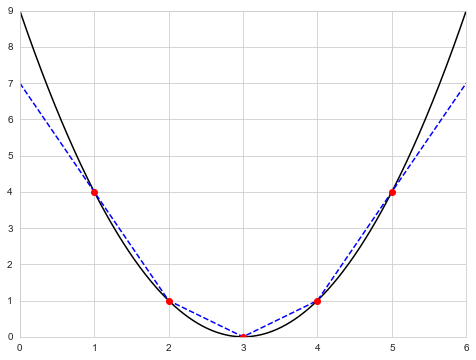

In [35]:
yi_scipy_interp = RegularGridInterpolator([x_known], f_known, 
                                          method='linear',bounds_error=False,fill_value=None)
output = yi_scipy_interp(x_true)
lin_fig(x_true,f_true,output)

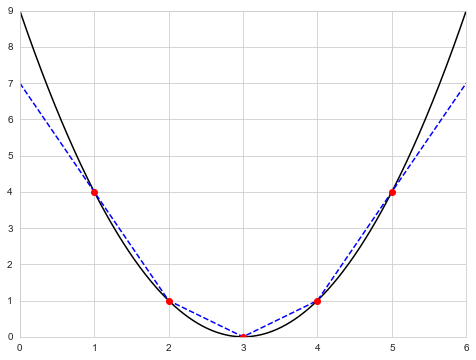

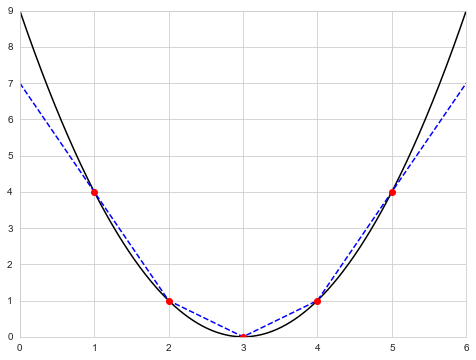

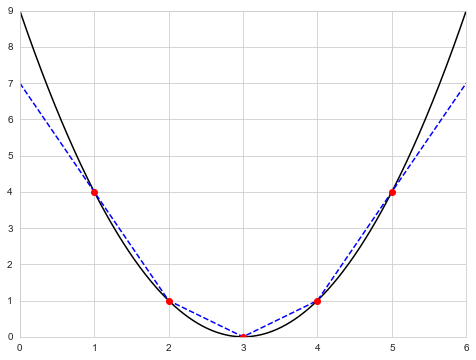

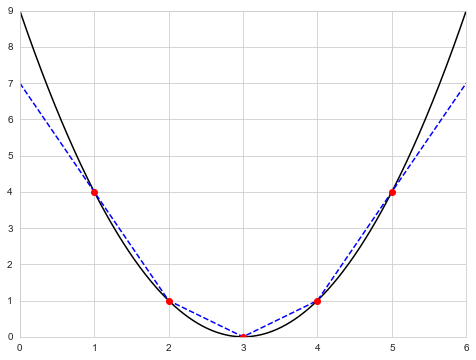

In [13]:
output = np.stack(([np.empty_like(x_true)]*4), axis=1)
linear_interp.interp_1d_vec(x_known,f_known,x_true,output[:,0])
prep = linear_interp.interp_1d_prep(len(x_true))
linear_interp.interp_1d_vec_mon(prep,x_known,f_known,x_true,output[:,1])
linear_interp.interp_1d_vec_mon_rep(prep,x_known,f_known,x_true,output[:,2])
linear_interp.interp_1d_vec_mon_noprep(x_known,f_known,x_true,output[:,3])

for i in range(4):
    lin_fig(x_true,f_true,output[:,i])